In [5]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import nlopt
import os
from meep_material import lorentzfunc, lorentzerr, lorentzfit

In [6]:
lambda_min = 0.4
lambda_max = 0.7
fmin = 1 / lambda_min
fmax = 1 / lambda_max
fcen = 0.5 * (fmin+fmax)
df = fmax - fmin
resolution = 200
nfreq = 25

In [3]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=50
                   ):    

    # 1. 데이터 로드 및 전처리
    data = np.genfromtxt(Material_data_csv, delimiter=",")
    wl = data[:, 0] * 1e6  # 파장 (µm)
    n_data = data[:, 1] + 1j * data[:, 2]
    eps_all = np.square(n_data) - eps_inf

    # 피팅 범위로 데이터 선택
    mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
    wl_fit, eps_fit = wl[mask], eps_all[mask]
    freqs_fit = 1 / wl_fit

    # 2. Lorentzian 피팅 최적화
    ps = np.zeros((iteration, 3 * num_lorentzians))
    errors = np.zeros(iteration)
    for m in range(iteration):
        p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
        ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
        print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
    best = np.argmin(errors)
    print(f"Optimal error: {errors[best]:.6f}")

    # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성
    suscept = []
    for i in range(num_lorentzians):
        freq_param = ps[best][3*i + 1]
        gamma = ps[best][3*i + 2]
        if freq_param == 0:
            sigma = ps[best][3*i + 0]
            suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            sigma = ps[best][3*i + 0] / freq_param**2
            suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))

    return eps_inf, suscept

sio2_data_path = "/mp/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/SiO2_palik_data.csv"
al_data_path = "/mp/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/Al_Palik/CSV/Al_palik_data.csv"
andp_data_path = "/mp/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/aNDP/CSV/aNPD_PFA_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.000024
Iteration   1, error: 0.000009
Iteration   2, error: 0.000013
Iteration   3, error: 0.000004
Iteration   4, error: 0.000033
Iteration   5, error: 0.000017
Iteration   6, error: 0.000010
Iteration   7, error: 0.000028
Iteration   8, error: 0.000011
Iteration   9, error: 0.000008
Iteration  10, error: 0.000008
Iteration  11, error: 0.000022
Iteration  12, error: 0.000035
Iteration  13, error: 0.000046
Iteration  14, error: 0.000006
Iteration  15, error: 0.000541
Iteration  16, error: 0.000029
Iteration  17, error: 0.000009
Iteration  18, error: 0.000141
Iteration  19, error: 0.001829
Iteration  20, error: 0.000091
Iteration  21, error: 0.000019
Iteration  22, error: 0.000014
Iteration  23, error: 0.000007
Iteration  24, error: 0.000037
Iteration  25, error: 0.000011
Iteration  26, error: 0.000020
Iteration  27, error: 0.000004
Iteration  28, error: 0.000077
Iteration  29, error: 0.000007
Iteration  30, error: 0.000004
Iteration  31, error: 0.000011
Iteratio

In [4]:
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities=suscept_sio2) # SiO2 
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP 
Cathode = mp.Medium(epsilon=eps_inf_al, E_susceptibilities = suscept_al) # Al

In [7]:
### ----- Refractive index ----- ###
CoverLayer = mp.Medium(index=1.0) # SiN
ITO = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기

In [13]:
Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

pml_layer = 0.5

print(Glass_layer+Cover_layer+Cathode_layer+aNDP_layer+ITO_layer+Alq3_layer)

2.0


In [14]:
# PML 경계조건
boundary_layers = [mp.PML(pml_layer)] 

In [ ]:
### 지금 이 cell 공간은 경민 코드
geometry = [
    # Glass
    mp.Block(
        center=mp.Vector3(0, 0, 2.49),
        size=mp.Vector3(30, 1.37, 3.72),
        material=Glass
    ),
    # Cover layer
    mp.Block(
        center=mp.Vector3(0, 0, 0.595),
        size=mp.Vector3(mp.inf, mp.inf, 0.07),
        material=CoverLayer
    ),
    # ITO
    mp.Block(
        center=mp.Vector3(0, 0, 0.06),
        size=mp.Vector3(mp.inf, mp.inf, 0.10),
        material=ITO
    ),
    # aNDP
    mp.Block(
        center=mp.Vector3(0, 0, 0.0),
        size=mp.Vector3(mp.inf, mp.inf, 0.485),
        material=aNDP
    ),
    # Alq3
    mp.Block(
        center=mp.Vector3(0, 0, 0),
        size=mp.Vector3(30, 0.06, 0),
        material=Alq3
    ),
    # Cathode
    mp.Block(
        center=mp.Vector3(0, 0.15, 0),
        size=mp.Vector3(30, 0.3, 0),
        material=Cathode
    )
]

In [8]:
### ----- Thickness ----- ###
tPML = round(lambda_max * 0.5, 3)  # 0.35
tGlass = round(1.37, 2) #뒤에서 PML까지 연장해야함
tCoverLayer = round(0.07, 3)
tITO = round(0.15, 3)
tNDP = round(0.05, 3)
tAlq3 = round(0.06, 3)
tCathode = round(0.3, 3)

tOLED = round(tGlass + tCoverLayer + tITO + tNDP + tAlq3 + tCathode, 3)

### ----- Simulation region ----- ###
Sx = round(30, 3)
Sy = round(0, 3)
Sz = round(tOLED+tPML, 3)

cell_size = mp.Vector3(Sx, Sy, Sz)

print("cell_size: ", cell_size)
print("tPML: ", tPML)
print("tGlass: ", tGlass)
print("tCoverLayer: ", tCoverLayer)
print("tITO: ", tITO)
print("tNDP: ", tNDP)
print("tAlq3: ", tAlq3)
print("tCathode: ", tCathode)
print("tOLED: ", tOLED)

cell_size:  Vector3<30.0, 0.0, 2.35>
tPML:  0.35
tGlass:  1.37
tCoverLayer:  0.07
tITO:  0.15
tNDP:  0.05
tAlq3:  0.06
tCathode:  0.3
tOLED:  2.0


In [12]:
# OLED 구조 정의 (Lumerical 반영)

first_layer = -(Sz/2)
geometry = [
    mp.Block(material=Glass,
             size=mp.Vector3(Sx, Sy, tGlass+tPML),
             center=mp.Vector3(z=first_layer + tCathode + tAlq3 + tNDP + tITO + tCoverLayer + (tGlass+tPML)/2)),

    mp.Block(material=CoverLayer,
             size=mp.Vector3(Sx, Sy, tCoverLayer),
             center=mp.Vector3(z=first_layer + tCathode + tAlq3 + tNDP + tITO + tCoverLayer/2)),
    
    mp.Block(material=ITO,
             size=mp.Vector3(Sx, Sy, tITO),
             center=mp.Vector3(z=first_layer + tCathode + tAlq3 + tNDP + tITO/2)),
    
    mp.Block(material=aNDP,
             size=mp.Vector3(Sx, Sy, tNDP),
             center=mp.Vector3(z=first_layer + tCathode + tAlq3 + tNDP/2)),

    mp.Block(material=Alq3,
             size=mp.Vector3(Sx, Sy, tAlq3),
             center=mp.Vector3(z=first_layer + tCathode + tAlq3/2)),

    mp.Block(material=Cathode,
             size=mp.Vector3(Sx, Sy, tCathode),
             center=mp.Vector3(z=first_layer + tCathode/2)),
]

In [13]:
print("geometry: ", first_layer + tCathode + tAlq3 + tNDP + tITO + tCoverLayer + (tGlass+tPML)/2)

geometry:  0.31500000000000017


In [17]:
### ----- 다이폴 소스 설정 (OLED 발광층에서 발생) ----- ###
'''Lumerial에서 0.33에 위치함 -> Cathode/2 = 0.3 & Alq3/2 = 0.03 '''

dipole_z = first_layer + tCathode + tAlq3/2  # 다이폴이 위치할 평면
single_dipole = True  # True: single dipole, False: multiple dipoles
num_dipoles = 1  # Number of dipoles, 1개로 동작 함

if single_dipole:
    sources = [mp.Source(mp.ContinuousSource(fcen),
                     component=mp.Ez,
                     center=mp.Vector3(x=0, z=dipole_z))]
else:
    dipole_x_positions = [i * (Sx / (num_dipoles + 1)) - Sx / 2 for i in range(1, num_dipoles + 1)]
    sources = [
        mp.Source(mp.ContinuousSource(frequency=1.0),
                component=mp.Ez,
                center=mp.Vector3(x=x_pos, z=dipole_z))
        for x_pos in dipole_x_positions]

     block, center = (0,0,2.49)
          size (1e+20,1e+20,3.72)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0.595)
          size (1e+20,1e+20,0.07)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0.06)
          size (1e+20,1e+20,0.1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0)
          size (1e+20,1e+20,0.485)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0)
          size (1e+20,1e+20,0.48)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,0,0)
          size (1e+20,1e+20,0.33)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)


<Axes: xlabel='X', ylabel='Z'>

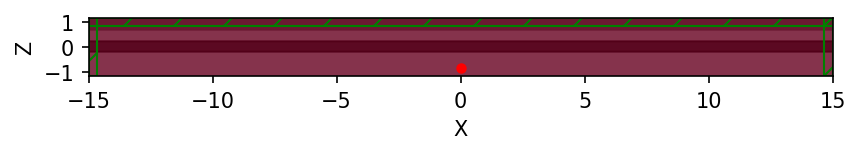

In [18]:
#test

# === 시뮬레이션 설정 === #
sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    eps_averaging=False)

plt.figure(dpi=150)
sim.plot2D(fields=mp.Ez, output_plane=mp.Volume(center=mp.Vector3(y=0), size=mp.Vector3(Sx, 0, Sz)))

     block, center = (0,0,2.49)
          size (1e+20,1e+20,3.72)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0.595)
          size (1e+20,1e+20,0.07)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0.06)
          size (1e+20,1e+20,0.1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0)
          size (1e+20,1e+20,0.485)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0)
          size (1e+20,1e+20,0.48)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,0,0)
          size (1e+20,1e+20,0.33)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)


<Axes: xlabel='X', ylabel='Z'>

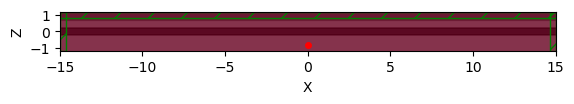

In [19]:
sim.plot2D(fields=mp.Ez, output_plane=mp.Volume(center=mp.Vector3(y=0), size=mp.Vector3(Sx, 0, Sz)))

In [20]:
plt.show()